In [1]:
import sqlite3
import pandas as pd
import numpy as np
from datetime import datetime 

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style('white')
%matplotlib inline

import pickle

from sklearn.cross_validation import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import scale
from sklearn import cross_validation
from sklearn import mixture

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dbfile = 'project_may9_649pm.db'
conn = sqlite3.connect(dbfile)

In [3]:
platform = 'tw'
platform_long = 'twitter'
condition = 'depression'
test_name = 'cesd'
test_cutoff = 21
photos_rated = True
has_test = True
gb_types = ['created_date','weekly','user_id'] # note "weekly" not "post" as in instagram version
periods = ['before','after']
turn_points = ['from_diag','from_susp']
fields = "id, text, has_url"
clfs = ['lr','rf']

report_sample_size = False # simple reporting feature
load_from_pickle = True # loads entire data dict, including masters, from pickle file
final_pickle = False # pickles entire data dict after all masters are created
populate_wordfeats_db = False # generates word features from reagan code

run_master = False 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': False, 
    'save_to_file' : False, 
    'density' : True, 
    'ml' : False, 
    'nhst' : False, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True
}

params = define_params(condition, test_name, test_cutoff, platform, platform_long, fields, photos_rated, has_test)

In [4]:
condition = 'depression'
platform = 'tw'
gb_types = ['created_date','weekly','user_id']
target = 'target'

In [5]:
data = {}
for dty in gb_types: 
    data[dty] = pd.read_csv('{cond}_{plat}_{dty}_MAIN.csv'.format(cond=condition, plat=platform, dty=dty))
    data[dty].drop(data[dty].columns[0], 1, inplace=True) # drops index

/Users/andrew/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
gb_type = 'weekly'
mdf = data[gb_type].copy()

# this mask isn't exhaustive...but it is meant to cover cases where tweets just don't give much useful info
mask = (mdf.LabMT_happs != 0) & (mdf.ANEW_happs != 0) & (mdf.LabMT_num_words!=0)
mdf = mdf.ix[mask,:]

tpop = mdf.ix[mdf.target==1,:]
cpop = mdf.ix[mdf.target==0,:]

print 'Num target ids:', tpop.user_id.unique().shape
print 'Num control ids:', cpop.user_id.unique().shape

# you should fix this up a bit...the reason you're sampling by user_id and not with a normal train_test_split is so you
# can take the class assignments and plot them on a time series for the entire span of a given subject
# still that's a bit messy and also not very principled with the numbers you picked.
Tuid_train = pd.Series(tpop.user_id.unique()).sample(70)
Cuid_train = pd.Series(cpop.user_id.unique()).sample(80)
uid_train = pd.concat([Tuid_train,Cuid_train]).values

df_train = mdf.ix[mdf.user_id.isin(uid_train),:]
df_test = mdf.ix[~mdf.user_id.isin(uid_train),:]

predictors = params['vars'][platform][gb_type]['model']

X = mdf[predictors].copy()

X_train = df_train[predictors].copy()

X_test = df_test[predictors].copy()

y_train = df_train[target]
y_test = df_test[target]

Num target ids: (90,)
Num control ids: (99,)


## GMM model selection with BIC

Note that if you leave in the zero-values for LabMT_happs, LabMT_word_count, etc, then the model selects 4 components instead of 2, since it thinks of the density bumps around zero for each class as their own compoonents.  So you took them out before running the model selection (well, you actually didn't take them out the first time and were surprised to see 4 components recommended...)

### But it's not always 2-classes, even with the 0s taken out!

In [64]:
# 2-class GMM fit
gmm2 = mixture.GMM( n_components=2 )

fit2 = gmm2.fit_predict(X)
mdf['comp2'] = fit2

#print 'fit to data:'
#print pd.Series(gmm2.score(X_test, y_test)).describe()
print 'BIC for 2-component mix:', gmm2.bic(X)

BIC for 2-component mix: 2715714.17485


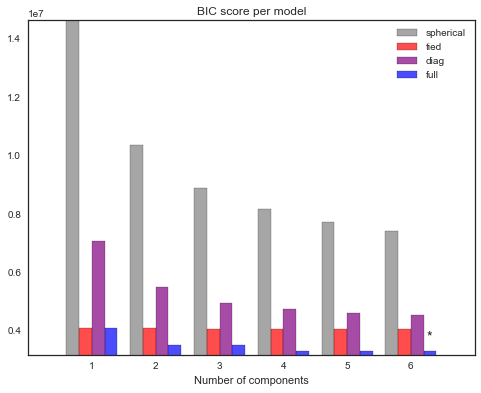

Optimal number of mixture components: 6
BIC for optimal (6) component mix: 4566857.43425


In [37]:
opt_comp = select_gmm(X).n_components
print 'Optimal number of mixture components:', opt_comp

gmmo = mixture.GMM( n_components=opt_comp )

fit = gmmo.fit_predict(X)
mdf['comp'] = fit

print 'BIC for optimal ({}) component mix:'.format(opt_comp), gmmo.bic(X)

In [65]:
num_comps = 2
# num_comps = opt_comp

In [9]:
#pd.DataFrame(np.round(gmm2.means_,3).T, columns=['Comp{}_mean'.format(x) for x in np.arange(num_comps)], index=X.columns)

### IDs to use:

339465627

These are user_id values that generate a compelling break from one class to another around diag_date

user_id 1389531
display line at: 2015-11-10 00:00:00


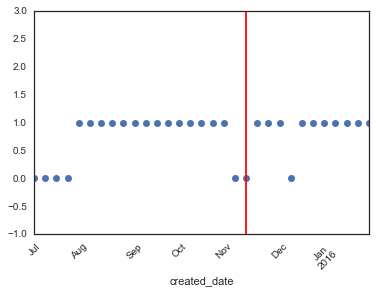

user_id 7485392
display line at: 2013-02-25 00:00:00


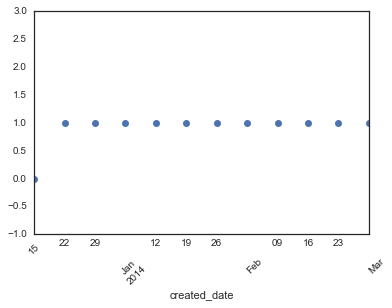

user_id 14474758
display line at: 2013-07-23 00:00:00


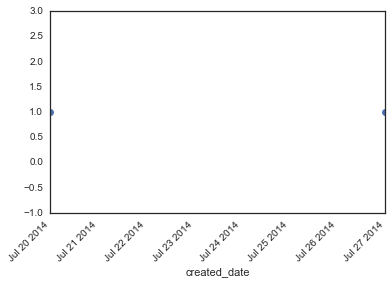

user_id 15410267
display line at: 2013-05-04 00:00:00


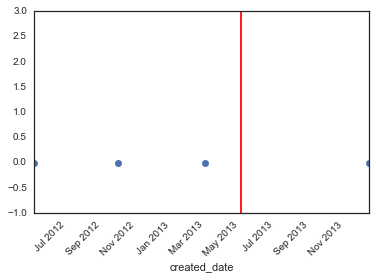

user_id 15410529
display line at: 2014-06-15 00:00:00


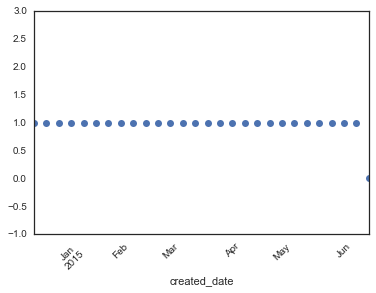

user_id 15447907
display line at: 2013-04-15 00:00:00


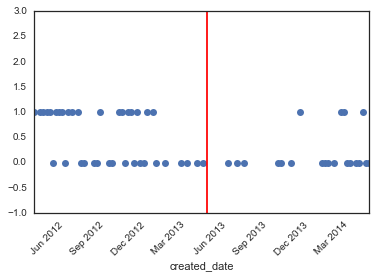

user_id 16512428
display line at: 2014-03-03 00:00:00


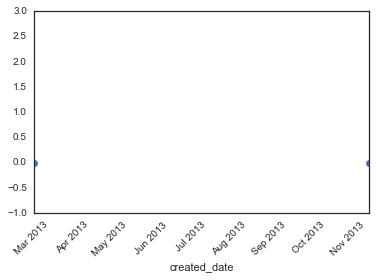

user_id 18007596
display line at: 2013-10-02 00:00:00


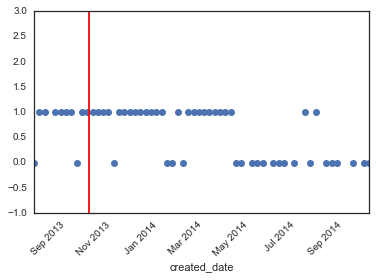

user_id 20993903
display line at: 2015-01-07 00:00:00


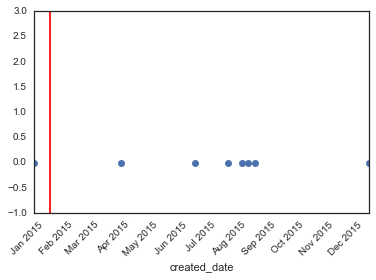

user_id 23188280
display line at: 2016-01-06 00:00:00


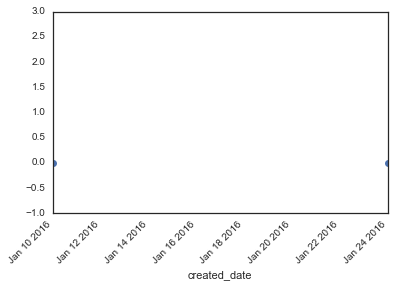

user_id 23277059
display line at: 2014-12-17 00:00:00


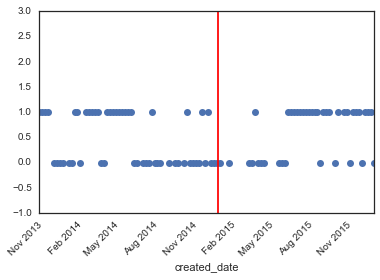

user_id 26679555
display line at: 2013-01-19 00:00:00


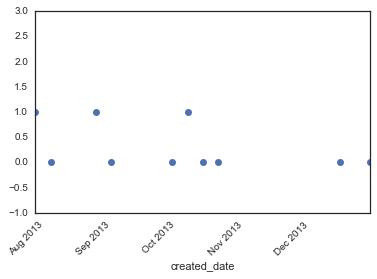

user_id 26933773
display line at: 2014-04-03 00:00:00


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735434.0, right=735434.0
  'left=%s, right=%s') % (left, right))


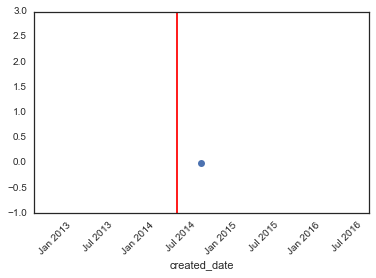

user_id 34503848
display line at: 2014-02-20 00:00:00


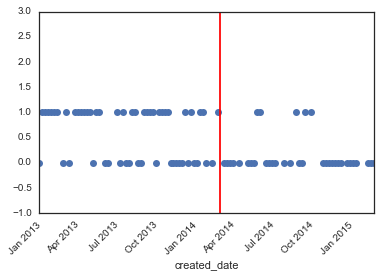

user_id 36702307
display line at: 2015-01-14 00:00:00


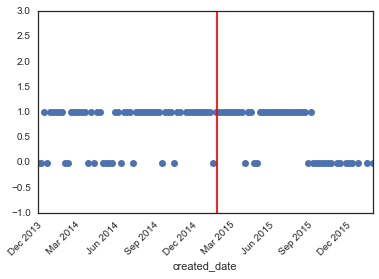

user_id 37462480
display line at: 2014-02-01 00:00:00


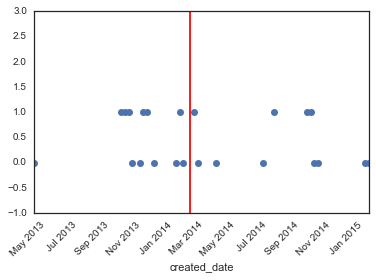

user_id 38441362
display line at: 2014-10-16 00:00:00


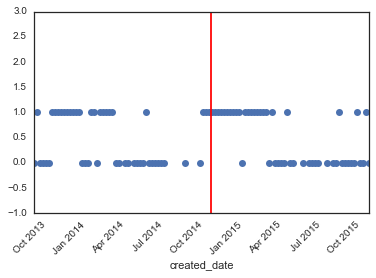

user_id 38680110
display line at: 2013-05-24 00:00:00


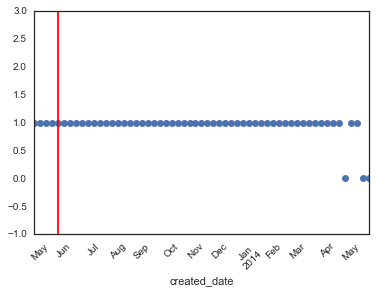

user_id 38911539
display line at: 2013-10-15 00:00:00


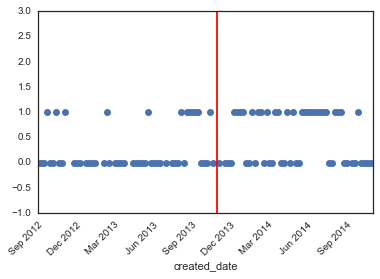

user_id 38921285
display line at: 2013-09-05 00:00:00


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735203.0, right=735203.0
  'left=%s, right=%s') % (left, right))


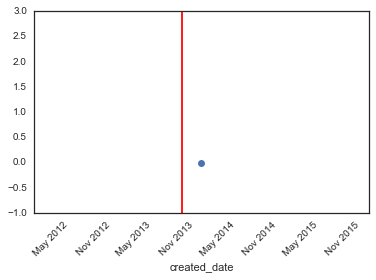

user_id 47270283
display line at: 2014-07-01 00:00:00


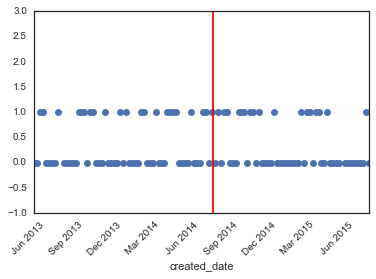

user_id 48562326
display line at: 2013-01-11 00:00:00


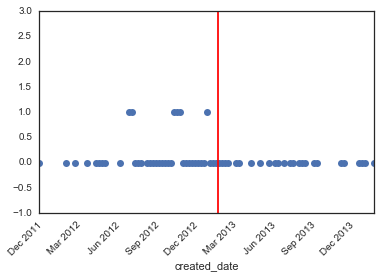

user_id 53662151
display line at: 2015-05-07 00:00:00


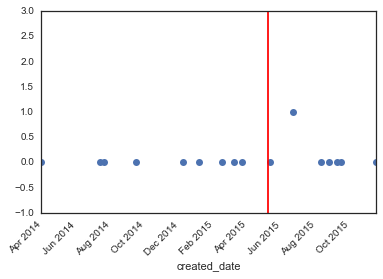

user_id 54362643
display line at: 2013-05-15 00:00:00


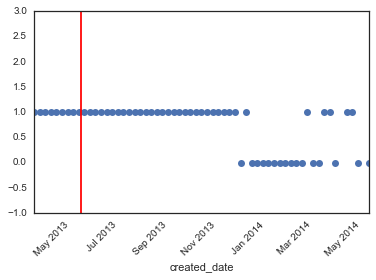

user_id 56991766
display line at: 2013-01-10 00:00:00


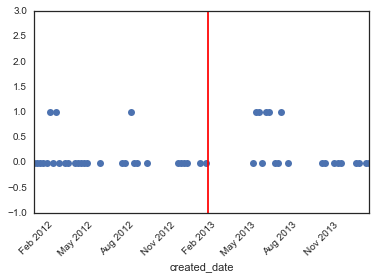

user_id 61283930
display line at: 2013-04-01 00:00:00


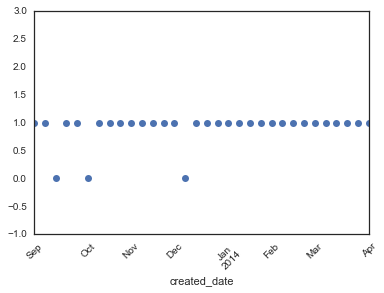

user_id 67388999
display line at: 2015-03-01 00:00:00


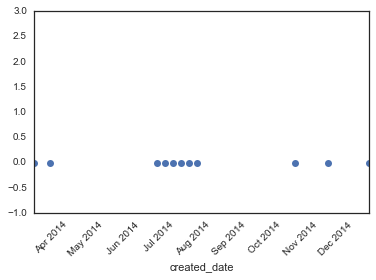

user_id 69289991
display line at: 2014-03-07 00:00:00


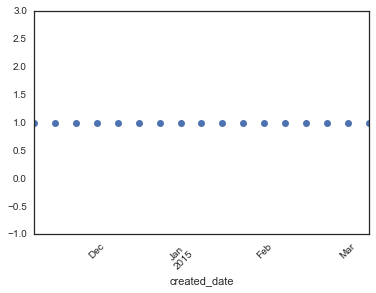

user_id 71567946
display line at: 2015-10-10 00:00:00


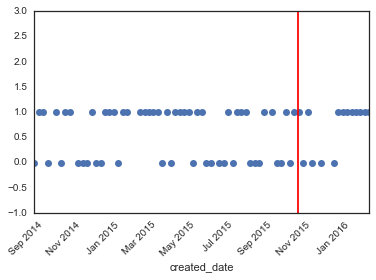

user_id 72399456
display line at: 2014-06-27 00:00:00


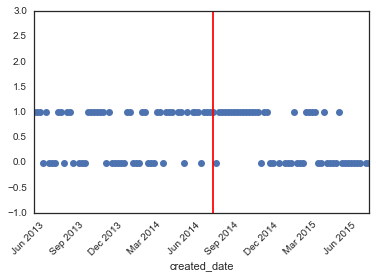

user_id 74414954
display line at: 2013-07-01 00:00:00


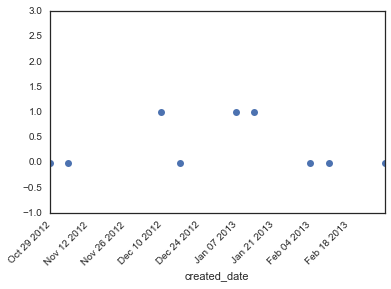

user_id 90117107
display line at: 2015-09-19 00:00:00


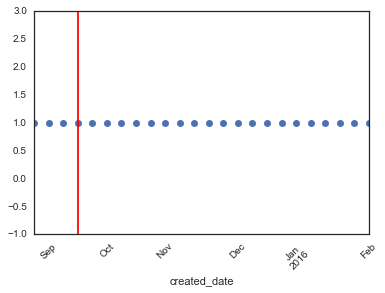

user_id 92785787
display line at: 2014-04-08 00:00:00


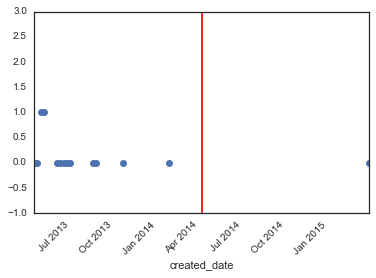

user_id 93672462
display line at: 2013-07-01 00:00:00


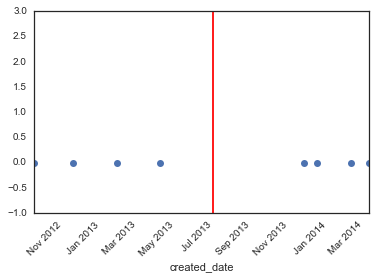

user_id 109450456
display line at: 2013-08-12 00:00:00


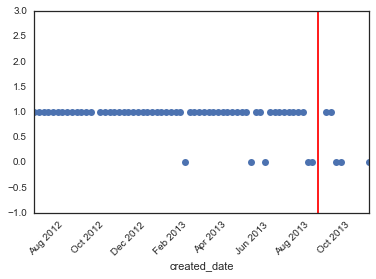

user_id 154568163
display line at: 2014-09-02 00:00:00


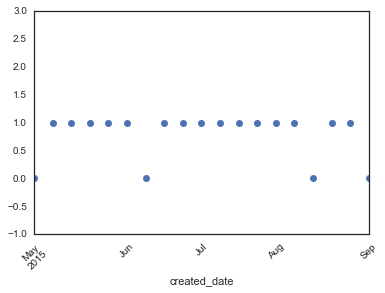

user_id 175897917
display line at: 2014-04-17 00:00:00


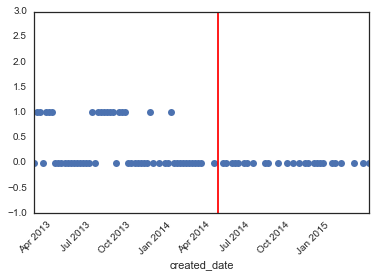

user_id 196327444
display line at: 2015-11-14 00:00:00


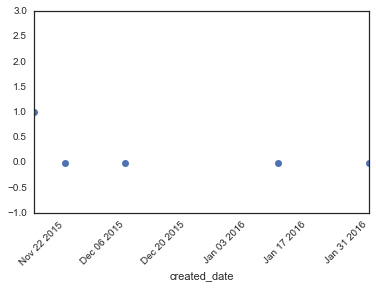

user_id 204145537
display line at: 2013-11-18 00:00:00


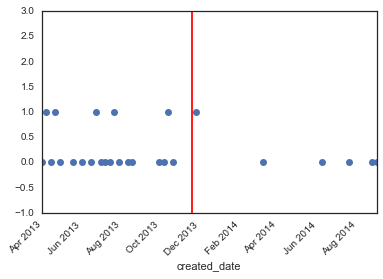

user_id 218348554
display line at: 2014-01-26 00:00:00


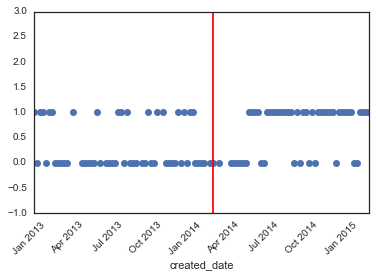

user_id 297126956
display line at: 2015-09-19 00:00:00


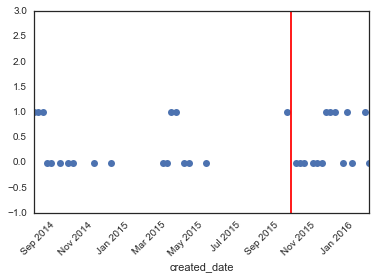

user_id 306686875
display line at: 2014-02-08 00:00:00


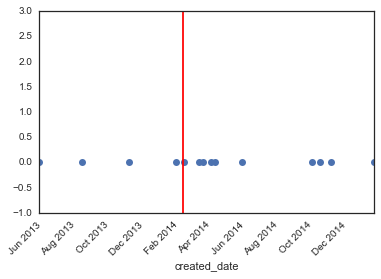

user_id 334678841
display line at: 2013-06-20 00:00:00


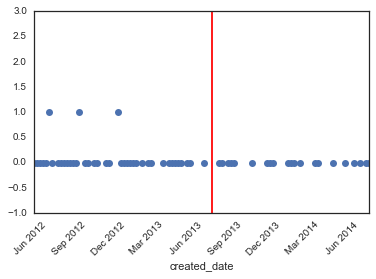

user_id 339465627
display line at: 2015-01-15 00:00:00


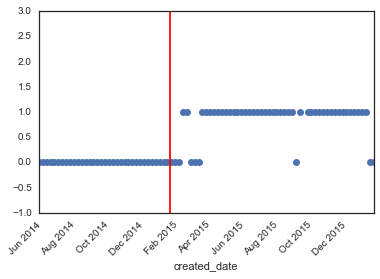

user_id 341082144
display line at: 2015-06-11 00:00:00


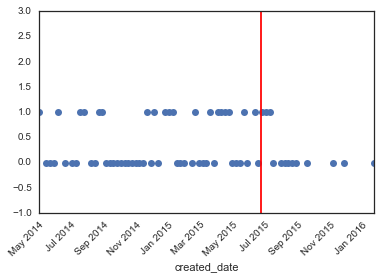

user_id 348757125
display line at: 2013-09-01 00:00:00


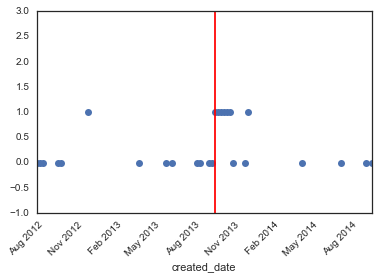

user_id 388668720
display line at: 2013-03-25 00:00:00


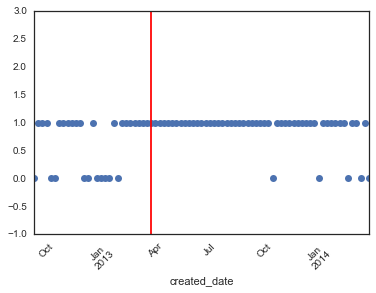

user_id 391137434
display line at: 2013-11-14 00:00:00


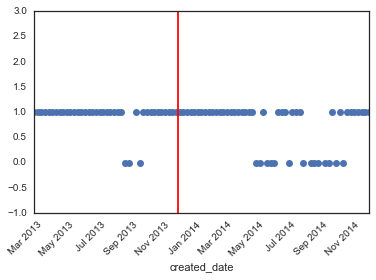

user_id 409373977
display line at: 2015-02-14 00:00:00


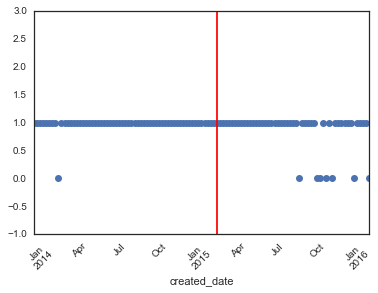

user_id 426255265
display line at: 2012-10-15 00:00:00


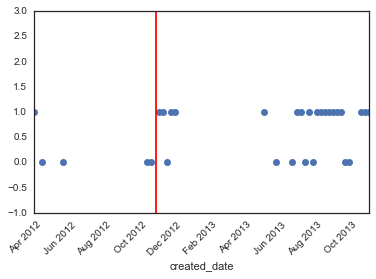

user_id 428360370
display line at: 2015-06-03 00:00:00


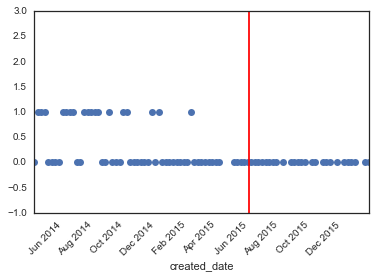

user_id 428708898
display line at: 2014-06-10 00:00:00


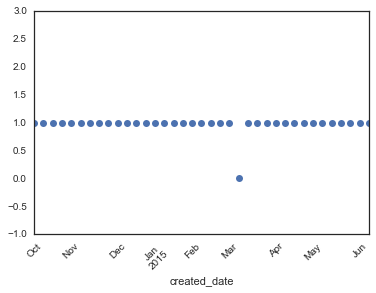

user_id 465034145
display line at: 2014-10-01 00:00:00


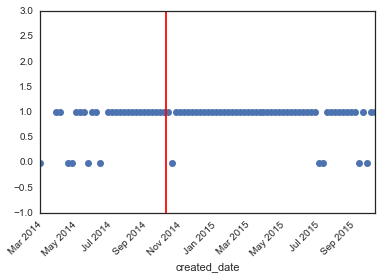

user_id 480173651
display line at: 2014-03-01 00:00:00


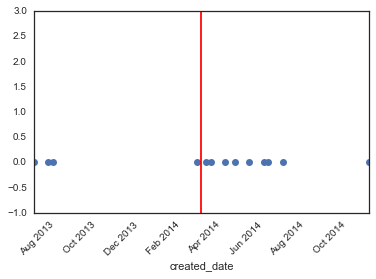

user_id 480435376
display line at: 2014-08-12 00:00:00


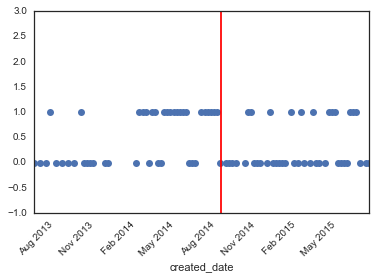

user_id 540455989
display line at: 2013-01-08 00:00:00


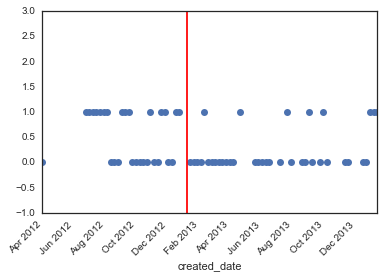

user_id 555606313
display line at: 2013-01-05 00:00:00


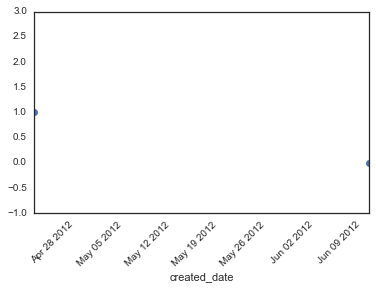

user_id 557436930
display line at: 2015-03-01 00:00:00


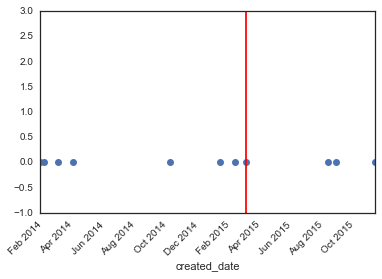

user_id 570864479
display line at: 2015-01-06 00:00:00


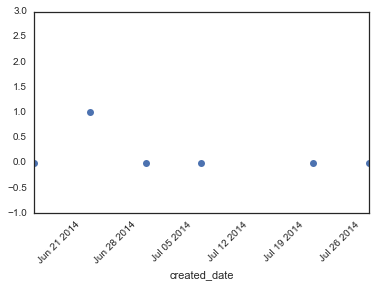

user_id 591317168
display line at: 2015-09-18 00:00:00


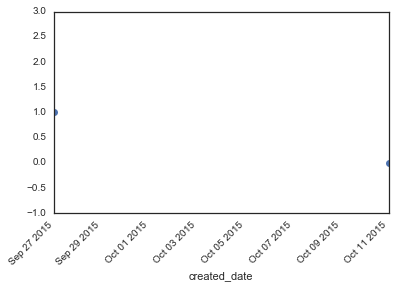

user_id 605412082
display line at: 2014-12-31 00:00:00


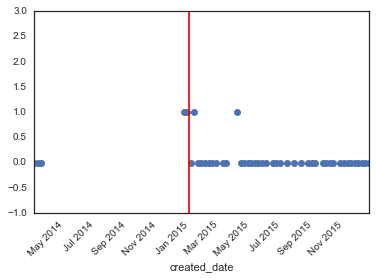

user_id 608366859
display line at: 2014-01-08 00:00:00


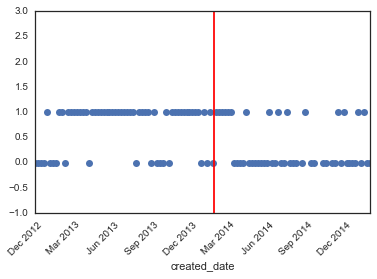

user_id 629547860
display line at: 2014-02-15 00:00:00


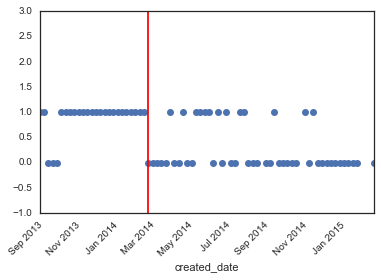

user_id 713165112
display line at: 2013-06-28 00:00:00


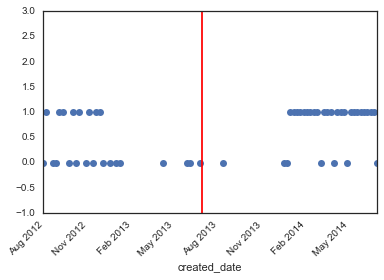

user_id 726058297
display line at: 2014-01-22 00:00:00


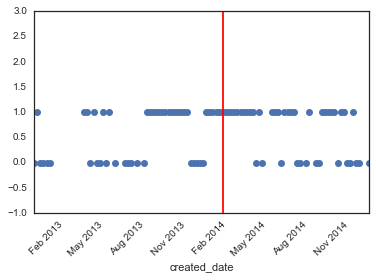

user_id 787219526
display line at: 2014-11-20 00:00:00


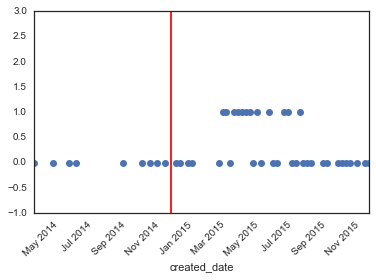

user_id 867046800
display line at: 2014-03-01 00:00:00


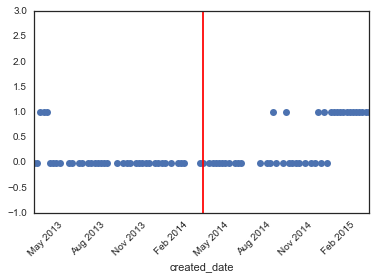

user_id 964460996
display line at: 2014-11-04 00:00:00


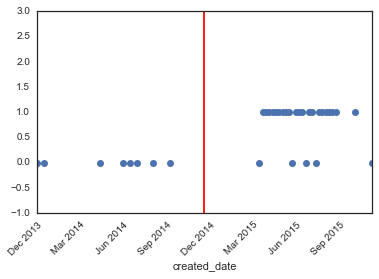

user_id 969486666
display line at: 2013-06-04 00:00:00


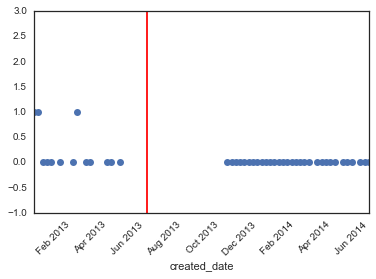

user_id 976990526
display line at: 2013-01-30 00:00:00


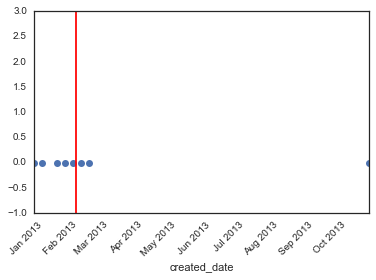

user_id 992433420
display line at: 2014-05-13 00:00:00


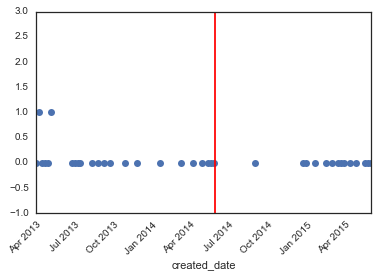

user_id 1002051104
display line at: 2015-10-15 00:00:00


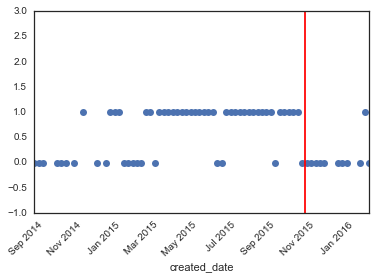

user_id 1216062650
display line at: 2015-12-16 00:00:00


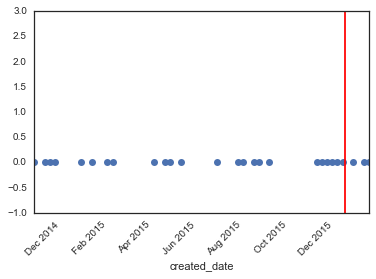

user_id 1322837568
display line at: 2014-05-03 00:00:00


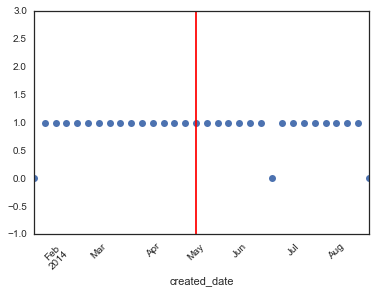

user_id 1428868201
display line at: 2016-02-02 00:00:00


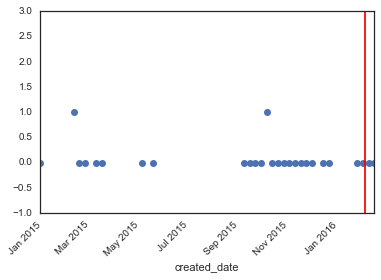

user_id 2192843814
display line at: 2014-01-26 00:00:00


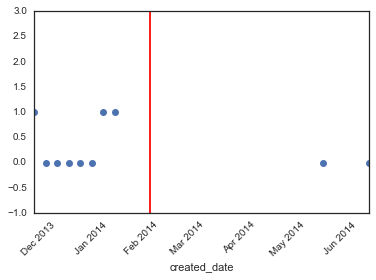

user_id 2251006502
display line at: 2014-05-05 00:00:00


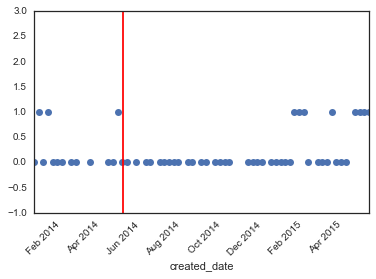

user_id 2281199874
display line at: 2014-01-03 00:00:00


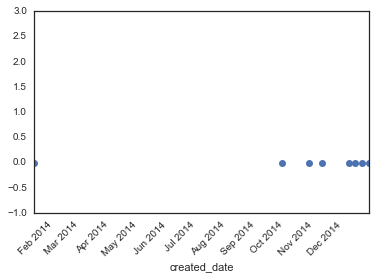

user_id 2302681856
display line at: 2014-02-07 00:00:00


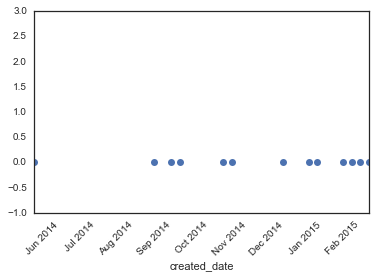

user_id 2313976729
display line at: 2015-01-26 00:00:00


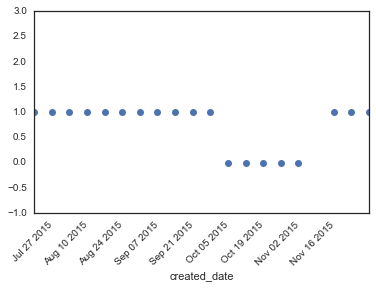

user_id 2347832498
display line at: 2014-11-14 00:00:00


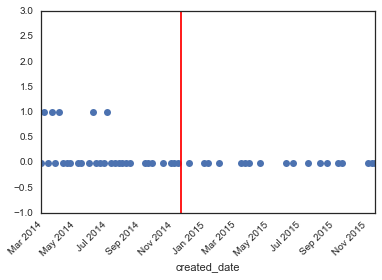

user_id 2366074495
display line at: 2014-07-14 00:00:00


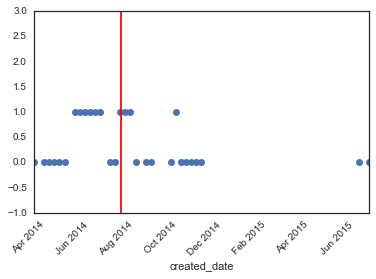

user_id 2416045034
display line at: 2014-05-02 00:00:00


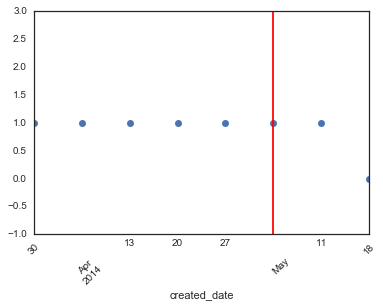

user_id 2419376958
display line at: 2014-01-02 00:00:00


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=735511.0, right=735511.0
  'left=%s, right=%s') % (left, right))


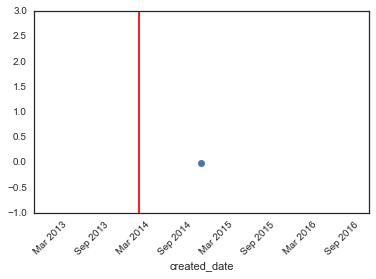

user_id 2452143637
display line at: 2014-03-07 00:00:00


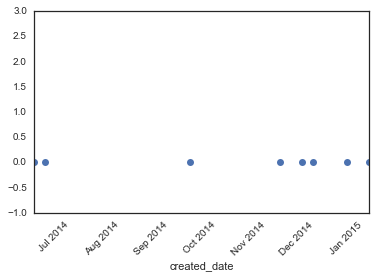

user_id 2464983331
display line at: 2014-11-28 00:00:00


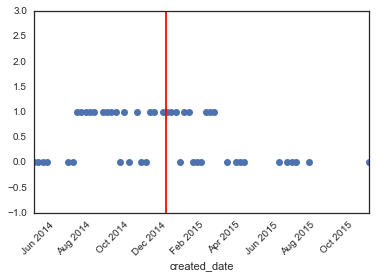

user_id 2782514460
display line at: 2014-12-07 00:00:00


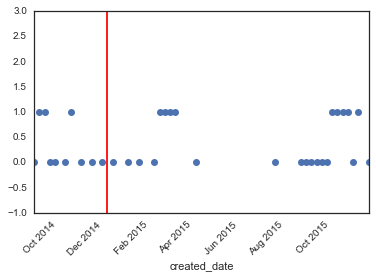

user_id 2903455919
display line at: 2015-06-01 00:00:00


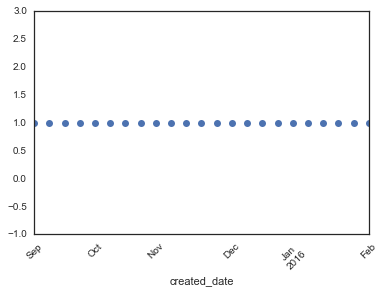

user_id 2906418756
display line at: 2014-06-11 00:00:00


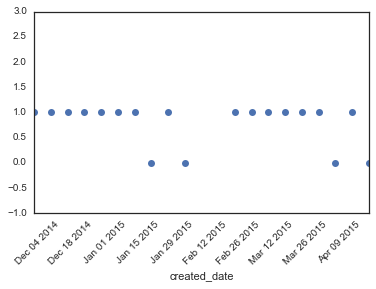

user_id 3665363774
display line at: 2015-12-10 00:00:00


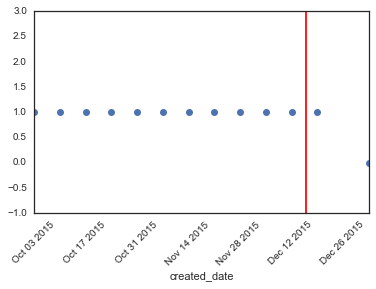

In [66]:

for sampid in mdf.ix[(mdf.target==1) & (mdf.comp2.notnull()),'user_id'].unique():
    plt.figure()
    oneuser = mdf.ix[mdf.user_id==sampid, :].copy()
    dd = oneuser.diag_date.unique()[0]

    diag_date = pd.to_datetime(dd)

    ts = oneuser.ix[:,'comp2'].copy()
    ts.index = pd.to_datetime(oneuser.created_date)

    ax = ts.plot(style='o')
    ymin, ymax = ax.get_ylim()
    plt.axvline(x=diag_date, color='red')

    ylim_max = num_comps+1
    plt.ylim([-1,ylim_max])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    print 'user_id', sampid
    print 'display line at:', diag_date
    
    plt.show()

fit to data:
count    1669.000000
mean      -99.374375
std        30.514937
min      -230.259947
25%      -121.781060
50%      -102.384834
75%       -71.860746
max       -47.892927
dtype: float64


IndexError: index 3 is out of bounds for axis 1 with size 3

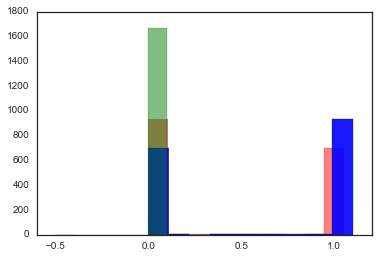

In [37]:
# optimal class number gmm fit 
gmmopt = mixture.GMM( n_components=opt_comp )

print 'fit to data:'
print pd.Series(gmm.score(X_test, y_test)).describe()

probs = gmm.predict_proba(X_test)
preds = gmm.predict(X_test)

conf_thresh = 0.9

_=plt.hist(probs[:,0]*1.05, color='red', alpha=0.5)
_=plt.hist(probs[:,1]*1.1, color='blue', alpha=0.9)
_=plt.hist(probs[:,2]*1.15, color='green', alpha=0.5)
_=plt.hist(probs[:,3]*1.2, color='cyan', alpha=0.5)
_=plt.hist(probs[:,4], color='orange', alpha=0.5)

ix = np.where((probs[:,0] > conf_thresh) |  (probs[:,1] > conf_thresh)|  (probs[:,2] > conf_thresh)|  (probs[:,3] > conf_thresh|  (probs[:,4] > conf_thresh)))[0]
probs_thresh = probs[ix,:]
y_test_thresh = y_test.values[ix]
predict_thresh = np.array([1 if x[1] > x[0] else 0 for x in probs_thresh])
print
print 'raw accuracy, all confidence:', np.sum(preds == y_test) / float(len(y_test))
print 'raw accuracy {} confidence:'.format(conf_thresh),np.sum(predict_thresh==y_test_thresh) / float(len(y_test_thresh))

print_confusion_matrix(predict_thresh, y_test_thresh, ctype='GMM')

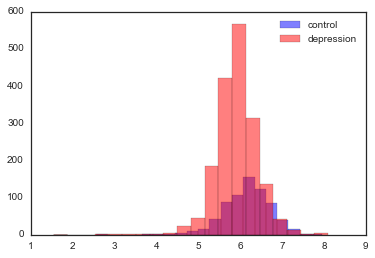

In [115]:
colors = df_test.target.apply(lambda x: 'blue' if x==0 else 'red')
plt.hist(df_test.LabMT_happs[df_test.target==0], color='blue', alpha=0.5, bins=20, label='control')
_=plt.hist(df_test.LabMT_happs[df_test.target==1], color='red', alpha=0.5, bins=20, label=condition)
_=plt.legend()

In [116]:
uids = df_test.ix[X_test.index, ['user_id','target']].reset_index()

prob_df = pd.concat([pd.DataFrame(probs, columns=['control','target']),uids], axis=1)
prob_df.index = prob_df['index'].values